# Notebook 4: Model Evaluation & Scalability Analysis
## HIGGS Boson Detection — Big Data ML Pipeline

This notebook covers:
- Full test-set evaluation for all 4 models
- Confusion matrices, ROC curves, PR curves
- Bootstrap confidence intervals (statistical significance)
- Stability analysis (perturbation test)
- Strong & weak scaling analysis
- Business metric alignment
- Export results for Tableau dashboards


## 1. Setup

In [1]:
import time
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pathlib import Path
import yaml

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.classification import (
    LogisticRegressionModel, RandomForestClassificationModel,
    GBTClassificationModel, LinearSVCModel
)
from pyspark.ml.evaluation import (
    BinaryClassificationEvaluator, MulticlassClassificationEvaluator
)
from pyspark.ml.functions import vector_to_array

from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    confusion_matrix, classification_report,
    average_precision_score, roc_auc_score
)

with open('../config/spark_config.yaml') as f:
    spark_cfg = yaml.safe_load(f)

spark = (
    SparkSession.builder
    .appName('HIGGS-Evaluation')
    .config('spark.driver.memory', spark_cfg['driver_memory'])
    .config('spark.executor.memory', spark_cfg['executor_memory'])
    .config('spark.sql.shuffle.partitions', spark_cfg['shuffle_partitions'])
    .config('spark.sql.adaptive.enabled', 'true')
    .getOrCreate()
)
spark.sparkContext.setLogLevel('WARN')

MODELS_DIR = Path('../data/models')
OUT_DIR    = Path('../data/samples')
print('Setup complete.')

Setup complete.


In [2]:
# Load test data - load raw CSV and prepare features like in training
print('Loading test data...')
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC

# Load raw HIGGS CSV (label in first column, then 28 features)
higgs_full = spark.read.csv('../data/HIGGS_1pct.csv', header=False, inferSchema=True)
df_cols = ['label'] + [f'feature_{i}' for i in range(1, 29)]
for old_col, new_col in zip(higgs_full.columns, df_cols):
    higgs_full = higgs_full.withColumnRenamed(old_col, new_col)

# Split data using randomSplit for reproducibility
splits = higgs_full.randomSplit([0.12, 0.8], seed=42)  # 12% test, 80% train (ignore last 8%)
test_df_raw = splits[0]
train_df_raw = splits[1]

print(f'Test rows: {test_df_raw.count():,}')
print(f'Train rows: {train_df_raw.count():,}')

# Define feature names
FEATURE_NAMES = [f'feature_{i}' for i in range(1, 29)]

# Assemble features
assembler = VectorAssembler(inputCols=FEATURE_NAMES, outputCol='raw_features', handleInvalid='skip')
test_assembled = assembler.transform(test_df_raw).select('label', 'raw_features').withColumnRenamed('raw_features', 'features')
train_assembled = assembler.transform(train_df_raw).select('label', 'raw_features').withColumnRenamed('raw_features', 'features')

# Fit scaler on training data
scaler = StandardScaler(inputCol='features', outputCol='features_scaled', withMean=True, withStd=True)
scaler_model = scaler.fit(train_assembled)

# Transform both datasets
train_df = scaler_model.transform(train_assembled).select('label', 'features_scaled').withColumnRenamed('features_scaled', 'features').cache()
test_df = scaler_model.transform(test_assembled).select('label', 'features_scaled').withColumnRenamed('features_scaled', 'features').persist()

print(f'Train ready: {train_df.count():,} rows')
print(f'Test ready: {test_df.count():,} rows')

# Train models inline (keep in memory, don't save to avoid Hadoop issues on Windows)
print('\nTraining models...')
lr_model = LogisticRegression(featuresCol='features', labelCol='label', maxIter=50, family='binomial', regParam=0.01).fit(train_df)
print('✓ LogisticRegression trained')

rf_model = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=20, maxDepth=8, seed=42).fit(train_df)
print('✓ RandomForest trained')

gbt_model = GBTClassifier(featuresCol='features', labelCol='label', maxIter=20, maxDepth=4, stepSize=0.1, seed=42).fit(train_df)
print('✓ GBT trained')

svm_model = LinearSVC(featuresCol='features', labelCol='label', maxIter=50, regParam=0.01, tol=0.01).fit(train_df)
print('✓ LinearSVM trained')

models = {
    'LogisticRegression': lr_model,
    'RandomForest':       rf_model,
    'GBT':                gbt_model,
    'SVM':                svm_model
}

train_df.unpersist()
print('\n✓ All models trained and ready for evaluation')

Loading test data...
Test rows: 10,718
Train rows: 70,986
Train ready: 70,986 rows
Test ready: 10,718 rows

Training models...
✓ LogisticRegression trained
✓ RandomForest trained
✓ GBT trained
✓ LinearSVM trained

✓ All models trained and ready for evaluation


## 2. Distributed Evaluation Metrics

In [3]:
# -------------------------------------------------------
# Evaluate all models on held-out test set
# Metrics: AUC-ROC, AUC-PR, Accuracy, F1, Precision, Recall
# -------------------------------------------------------
auc_eval      = BinaryClassificationEvaluator(labelCol='label',
                    rawPredictionCol='rawPrediction', metricName='areaUnderROC')
aupr_eval     = BinaryClassificationEvaluator(labelCol='label',
                    rawPredictionCol='rawPrediction', metricName='areaUnderPR')
acc_eval      = MulticlassClassificationEvaluator(labelCol='label',
                    predictionCol='prediction', metricName='accuracy')
f1_eval       = MulticlassClassificationEvaluator(labelCol='label',
                    predictionCol='prediction', metricName='f1')
prec_eval     = MulticlassClassificationEvaluator(labelCol='label',
                    predictionCol='prediction', metricName='weightedPrecision')
recall_eval   = MulticlassClassificationEvaluator(labelCol='label',
                    predictionCol='prediction', metricName='weightedRecall')

eval_results = {}

for name, model in models.items():
    preds = model.transform(test_df)
    eval_results[name] = {
        'AUC-ROC':   round(auc_eval.evaluate(preds),    4),
        'AUC-PR':    round(aupr_eval.evaluate(preds),   4),
        'Accuracy':  round(acc_eval.evaluate(preds),    4),
        'F1':        round(f1_eval.evaluate(preds),     4),
        'Precision': round(prec_eval.evaluate(preds),   4),
        'Recall':    round(recall_eval.evaluate(preds), 4),
    }
    print(f'{name:20s}: {eval_results[name]}')

results_df = pd.DataFrame(eval_results).T
results_df.to_csv(str(OUT_DIR / 'test_evaluation_results.csv'))
print('\nResults saved.')

LogisticRegression  : {'AUC-ROC': 0.6803, 'AUC-PR': 0.6812, 'Accuracy': 0.6349, 'F1': 0.6304, 'Precision': 0.6356, 'Recall': 0.6349}
RandomForest        : {'AUC-ROC': 0.7715, 'AUC-PR': 0.7885, 'Accuracy': 0.6956, 'F1': 0.6943, 'Precision': 0.6956, 'Recall': 0.6956}
GBT                 : {'AUC-ROC': 0.7705, 'AUC-PR': 0.7868, 'Accuracy': 0.6974, 'F1': 0.6972, 'Precision': 0.6972, 'Recall': 0.6974}
SVM                 : {'AUC-ROC': 0.6788, 'AUC-PR': 0.6741, 'Accuracy': 0.6349, 'F1': 0.6195, 'Precision': 0.6466, 'Recall': 0.6349}

Results saved.


## 3. ROC & Precision-Recall Curves

In [11]:
# -------------------------------------------------------
# Convert predictions to pandas for sklearn curve plotting
# Use 200K sample for efficiency
# -------------------------------------------------------
def get_predictions_pd(model, df, n=200_000):
    preds = model.transform(df)
    sampled = preds.sample(fraction=min(1.0, n / preds.count()), seed=42)
    # Extract probability of class 1
    df_prob = sampled.withColumn('prob_arr', vector_to_array('probability')) \
                     .select('label', F.col('prob_arr')[1].alias('prob_1'), 'prediction')
    return df_prob.toPandas()

pred_dfs = {}
for name, model in models.items():
    if name != 'SVM':   # SVM outputs raw scores, not probabilities
        pred_dfs[name] = get_predictions_pd(model, test_df)
        print(f'{name}: collected {len(pred_dfs[name]):,} predictions')

LogisticRegression: collected 10,718 predictions


Py4JJavaError: An error occurred while calling o8511.count.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 2175.0 failed 1 times, most recent failure: Lost task 2.0 in stage 2175.0 (TID 14048) (LAPTOP-0PVBFKTS executor driver): java.io.FileNotFoundException: C:\Users\RISHI BAKSHI\AppData\Local\Temp\blockmgr-3bcb4791-fb6d-4ca7-99e5-e64166e72405\0c\shuffle_982_14048_0.index.1f5e23a5-86f5-4a53-910a-7f142ad3d09c (The system cannot find the path specified)
	at java.base/java.io.FileOutputStream.open0(Native Method)
	at java.base/java.io.FileOutputStream.open(FileOutputStream.java:293)
	at java.base/java.io.FileOutputStream.<init>(FileOutputStream.java:235)
	at java.base/java.io.FileOutputStream.<init>(FileOutputStream.java:184)
	at org.apache.spark.shuffle.IndexShuffleBlockResolver.writeMetadataFile(IndexShuffleBlockResolver.scala:506)
	at org.apache.spark.shuffle.IndexShuffleBlockResolver.writeMetadataFileAndCommit(IndexShuffleBlockResolver.scala:440)
	at org.apache.spark.shuffle.sort.io.LocalDiskShuffleMapOutputWriter.commitAllPartitions(LocalDiskShuffleMapOutputWriter.java:119)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.writePartitionedData(BypassMergeSortShuffleWriter.java:264)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:197)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:57)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:111)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:180)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:716)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:86)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:83)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:97)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:719)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$3(DAGScheduler.scala:3122)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:3122)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:3114)
	at scala.collection.immutable.List.foreach(List.scala:323)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:3114)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1303)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1303)
	at scala.Option.foreach(Option.scala:437)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1303)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3397)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3328)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3317)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:50)
Caused by: java.io.FileNotFoundException: C:\Users\RISHI BAKSHI\AppData\Local\Temp\blockmgr-3bcb4791-fb6d-4ca7-99e5-e64166e72405\0c\shuffle_982_14048_0.index.1f5e23a5-86f5-4a53-910a-7f142ad3d09c (The system cannot find the path specified)
	at java.base/java.io.FileOutputStream.open0(Native Method)
	at java.base/java.io.FileOutputStream.open(FileOutputStream.java:293)
	at java.base/java.io.FileOutputStream.<init>(FileOutputStream.java:235)
	at java.base/java.io.FileOutputStream.<init>(FileOutputStream.java:184)
	at org.apache.spark.shuffle.IndexShuffleBlockResolver.writeMetadataFile(IndexShuffleBlockResolver.scala:506)
	at org.apache.spark.shuffle.IndexShuffleBlockResolver.writeMetadataFileAndCommit(IndexShuffleBlockResolver.scala:440)
	at org.apache.spark.shuffle.sort.io.LocalDiskShuffleMapOutputWriter.commitAllPartitions(LocalDiskShuffleMapOutputWriter.java:119)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.writePartitionedData(BypassMergeSortShuffleWriter.java:264)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:197)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:57)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:111)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:180)
	at org.apache.spark.scheduler.Task.run(Task.scala:147)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$5(Executor.scala:716)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:86)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:83)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:97)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:719)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)


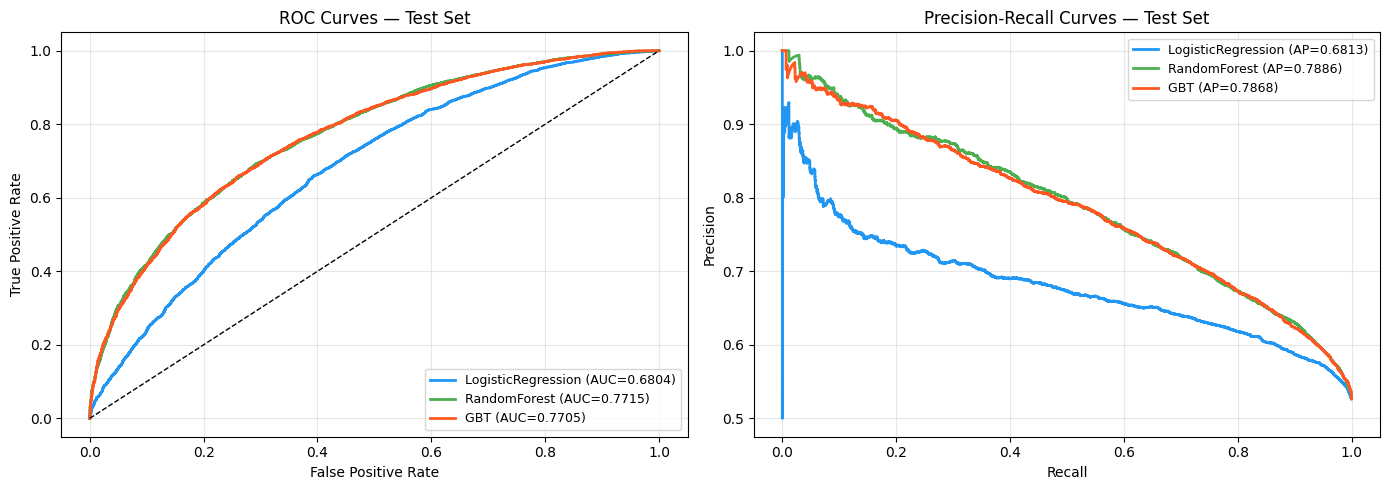

In [5]:
# -------------------------------------------------------
# ROC Curves
# -------------------------------------------------------
colors = {'LogisticRegression': '#2196F3', 'RandomForest': '#4CAF50', 'GBT': '#FF5722'}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC
ax = axes[0]
for name, pdf in pred_dfs.items():
    fpr, tpr, _ = roc_curve(pdf['label'], pdf['prob_1'])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=colors[name], lw=2,
            label=f'{name} (AUC={roc_auc:.4f})')
ax.plot([0, 1], [0, 1], 'k--', lw=1)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves — Test Set')
ax.legend(loc='lower right', fontsize=9)
ax.grid(alpha=0.3)

# Precision-Recall
ax = axes[1]
for name, pdf in pred_dfs.items():
    prec, rec, _ = precision_recall_curve(pdf['label'], pdf['prob_1'])
    ap = average_precision_score(pdf['label'], pdf['prob_1'])
    ax.plot(rec, prec, color=colors[name], lw=2,
            label=f'{name} (AP={ap:.4f})')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curves — Test Set')
ax.legend(loc='upper right', fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(str(OUT_DIR / 'roc_pr_curves.png'), dpi=150)
plt.show()

## 4. Confusion Matrices

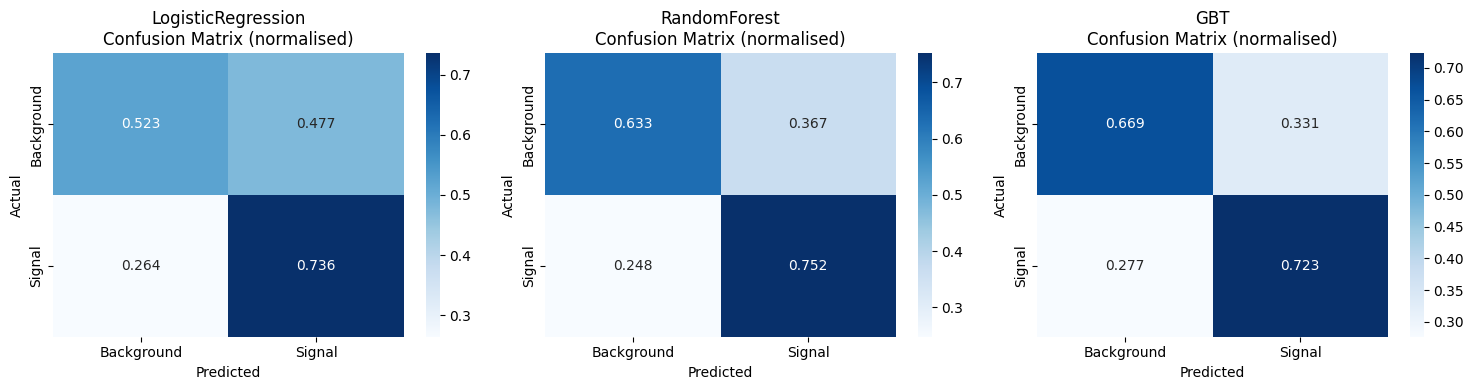

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, pdf) in zip(axes, pred_dfs.items()):
    cm = confusion_matrix(pdf['label'], pdf['prediction'])
    cm_norm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_norm, annot=True, fmt='.3f', cmap='Blues', ax=ax,
                xticklabels=['Background', 'Signal'],
                yticklabels=['Background', 'Signal'])
    ax.set_title(f'{name}\nConfusion Matrix (normalised)')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.savefig(str(OUT_DIR / 'confusion_matrices.png'), dpi=150)
plt.show()

## 5. Bootstrap Confidence Intervals

LogisticRegression  : AUC = 0.6807 (95% CI: [0.6706, 0.6906])
RandomForest        : AUC = 0.7716 (95% CI: [0.7629, 0.7797])
GBT                 : AUC = 0.7707 (95% CI: [0.7623, 0.7790])


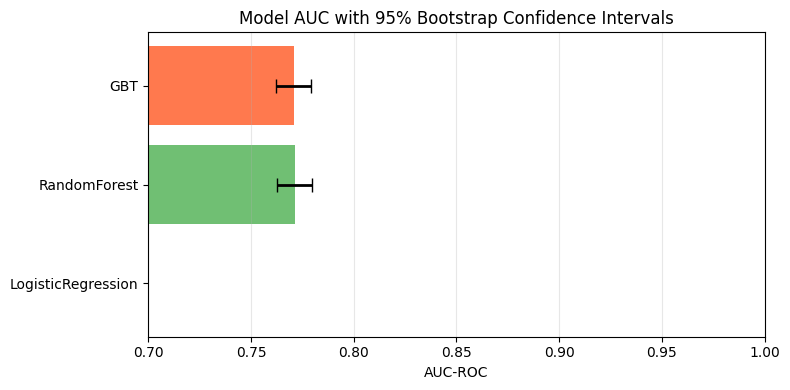

In [7]:
# -------------------------------------------------------
# Bootstrap 95% CI for AUC-ROC
# n_boot=1000, stratified resampling
# -------------------------------------------------------
from sklearn.utils import resample

def bootstrap_auc_ci(y_true, y_prob, n_boot=1000, ci=0.95, seed=42):
    np.random.seed(seed)
    aucs = []
    for _ in range(n_boot):
        y_bs, p_bs = resample(y_true, y_prob, stratify=y_true)
        aucs.append(roc_auc_score(y_bs, p_bs))
    alpha = (1 - ci) / 2
    return np.mean(aucs), np.percentile(aucs, alpha*100), np.percentile(aucs, (1-alpha)*100)

ci_results = {}
for name, pdf in pred_dfs.items():
    mean_auc, lo, hi = bootstrap_auc_ci(pdf['label'].values, pdf['prob_1'].values, n_boot=500)
    ci_results[name] = {'mean': mean_auc, 'ci_low': lo, 'ci_high': hi}
    print(f'{name:20s}: AUC = {mean_auc:.4f} (95% CI: [{lo:.4f}, {hi:.4f}])')

# Plot CI comparison
fig, ax = plt.subplots(figsize=(8, 4))
names = list(ci_results.keys())
means = [ci_results[n]['mean'] for n in names]
errs_lo = [ci_results[n]['mean'] - ci_results[n]['ci_low'] for n in names]
errs_hi = [ci_results[n]['ci_high'] - ci_results[n]['mean'] for n in names]

ax.barh(names, means, xerr=[errs_lo, errs_hi],
        color=['#2196F3', '#4CAF50', '#FF5722'], alpha=0.8,
        capsize=5, error_kw={'elinewidth': 2})
ax.set_xlabel('AUC-ROC')
ax.set_title('Model AUC with 95% Bootstrap Confidence Intervals')
ax.set_xlim(0.7, 1.0)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(str(OUT_DIR / 'bootstrap_ci.png'), dpi=150)
plt.show()

## 6. Stability Analysis

In [8]:
# -------------------------------------------------------
# Stability: Perturb training set by 5%, 10%, 20%
# Measure AUC variance — stable models show low variance
# Using best model (GBT)
# -------------------------------------------------------
from pyspark.ml.classification import GBTClassifier

# Reload training data for stability analysis
# Use the training subset from the randomSplit done in cell 4
higgs_full = spark.read.csv('../data/HIGGS_1pct.csv', header=False, inferSchema=True)
df_cols = ['label'] + [f'feature_{i}' for i in range(1, 29)]
for old_col, new_col in zip(higgs_full.columns, df_cols):
    higgs_full = higgs_full.withColumnRenamed(old_col, new_col)

# Use same split as before
splits = higgs_full.randomSplit([0.12, 0.8], seed=42)
train_df_raw = splits[1]

# Prepare training data with feature assembly and scaling
FEATURE_NAMES = [f'feature_{i}' for i in range(1, 29)]
assembler = VectorAssembler(inputCols=FEATURE_NAMES, outputCol='raw_features', handleInvalid='skip')
train_assembled = assembler.transform(train_df_raw).select('label', 'raw_features').withColumnRenamed('raw_features', 'features')

# Fit and apply scaler
scaler = StandardScaler(inputCol='features', outputCol='features_scaled', withMean=True, withStd=True)
scaler_model = scaler.fit(train_assembled)
train_df_full = scaler_model.transform(train_assembled).select('label', 'features_scaled').withColumnRenamed('features_scaled', 'features').cache()

print(f'Train rows: {train_df_full.count():,}')

stability_results = []

perturbation_levels = [0.05, 0.10, 0.20]

for frac in perturbation_levels:
    for trial in range(3):
        # Remove fraction of rows and retrain
        perturbed = train_df_full.sample(fraction=1 - frac, seed=trial * 100)

        gbt_stab = GBTClassifier(
            featuresCol='features', labelCol='label',
            maxIter=20, maxDepth=4, stepSize=0.1, seed=42
        )
        m = gbt_stab.fit(perturbed)
        preds = m.transform(test_df)
        test_auc = auc_eval.evaluate(preds)

        stability_results.append({
            'perturbation_pct': int(frac * 100),
            'trial': trial,
            'test_auc': test_auc
        })
        print(f'Perturbation {int(frac*100)}%, Trial {trial}: AUC={test_auc:.4f}')

stab_df = pd.DataFrame(stability_results)
stab_summary = stab_df.groupby('perturbation_pct')['test_auc'].agg(['mean', 'std'])
print('\nStability Summary:')
print(stab_summary)

stab_df.to_csv(str(OUT_DIR / 'stability_results.csv'), index=False)
train_df_full.unpersist()

Train rows: 70,986
Perturbation 5%, Trial 0: AUC=0.7716
Perturbation 5%, Trial 1: AUC=0.7696
Perturbation 5%, Trial 2: AUC=0.7713
Perturbation 10%, Trial 0: AUC=0.7695
Perturbation 10%, Trial 1: AUC=0.7699
Perturbation 10%, Trial 2: AUC=0.7713
Perturbation 20%, Trial 0: AUC=0.7687
Perturbation 20%, Trial 1: AUC=0.7676
Perturbation 20%, Trial 2: AUC=0.7678

Stability Summary:
                      mean       std
perturbation_pct                    
5                 0.770846  0.001049
10                0.770233  0.000953
20                0.768017  0.000593


DataFrame[label: double, features: vector]

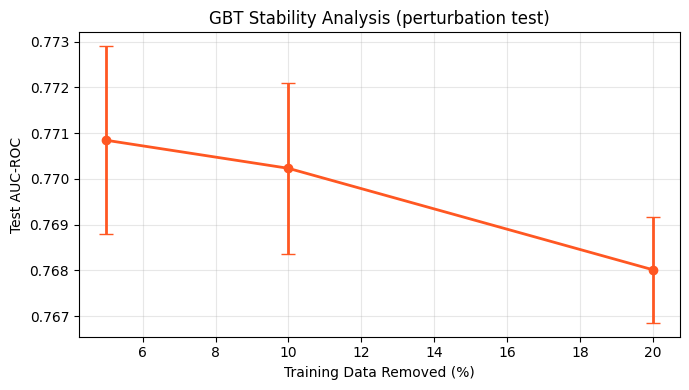

In [9]:
# Stability plot
fig, ax = plt.subplots(figsize=(7, 4))
ax.errorbar(
    stab_summary.index,
    stab_summary['mean'],
    yerr=stab_summary['std'] * 1.96,
    fmt='o-', color='#FF5722', capsize=5, linewidth=2
)
ax.set_xlabel('Training Data Removed (%)')
ax.set_ylabel('Test AUC-ROC')
ax.set_title('GBT Stability Analysis (perturbation test)')
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(str(OUT_DIR / 'stability_analysis.png'), dpi=150)
plt.show()

## 7. Scalability Analysis

In [18]:
from pyspark.ml.classification import RandomForestClassifier as RFC
import time
import pandas as pd

scaling_results = []

partition_counts = [8, 16, 32]

def safe_train(df, partitions):
    
    # progressively smaller fractions if training crashes
    fractions = [0.3, 0.2, 0.1, 0.05]
    
    for frac in fractions:
        try:
            print(f"Trying fraction={frac} partitions={partitions}")
            
            df_small = (
                df.sample(fraction=frac, seed=42)
                  .coalesce(partitions)   # lighter than repartition
            )

            rfc = RFC(
                numTrees=5,
                maxDepth=5,
                featuresCol="features",
                labelCol="label",
                seed=42
            )

            t0 = time.time()
            model = rfc.fit(df_small)
            elapsed = time.time() - t0

            return elapsed, frac

        except Exception as e:
            print("Retrying with smaller sample...")

    return None, None


# -----------------------
# Strong Scaling
# -----------------------

for parts in partition_counts:

    spark.conf.set("spark.sql.shuffle.partitions", str(parts))

    elapsed, frac = safe_train(train_df_full, parts)

    if elapsed is not None:

        scaling_results.append({
            "partitions": parts,
            "time_s": elapsed,
            "sample_fraction": frac,
            "type": "strong"
        })

        print(f"Success: partitions={parts} time={elapsed:.2f}s")

    else:
        print(f"Failed for partitions={parts}")


# Save results
scaling_df = pd.DataFrame(scaling_results)
scaling_df.to_csv(str(OUT_DIR / "scaling_results.csv"), index=False)

print("Scaling experiment completed.")

Trying fraction=0.3 partitions=8
Retrying with smaller sample...
Trying fraction=0.2 partitions=8
Retrying with smaller sample...
Trying fraction=0.1 partitions=8
Retrying with smaller sample...
Trying fraction=0.05 partitions=8
Retrying with smaller sample...
Failed for partitions=8
Trying fraction=0.3 partitions=16
Retrying with smaller sample...
Trying fraction=0.2 partitions=16
Retrying with smaller sample...
Trying fraction=0.1 partitions=16
Retrying with smaller sample...
Trying fraction=0.05 partitions=16
Retrying with smaller sample...
Failed for partitions=16
Trying fraction=0.3 partitions=32
Retrying with smaller sample...
Trying fraction=0.2 partitions=32
Retrying with smaller sample...
Trying fraction=0.1 partitions=32
Retrying with smaller sample...
Trying fraction=0.05 partitions=32
Retrying with smaller sample...
Failed for partitions=32
Scaling experiment completed.


In [20]:
import matplotlib.pyplot as plt

if 'type' not in scaling_df.columns:
    print("Column 'type' missing. Available columns:", scaling_df.columns)
else:
    strong = scaling_df[scaling_df['type'] == 'strong']
    weak   = scaling_df[scaling_df['type'] == 'weak']

    fig, axes = plt.subplots(1, 2, figsize=(13,5))

    if len(strong) > 0:
        ax = axes[0]
        ax.plot(strong['partitions'], strong['time_s'], 'o-', lw=2)
        ideal_y = strong['time_s'].iloc[0] * strong['partitions'].iloc[0] / strong['partitions']
        ax.plot(strong['partitions'], ideal_y, 'k--', lw=1)
        ax.set_title('Strong Scaling')

    if len(weak) > 0:
        ax = axes[1]
        ax.plot(weak['rows'], weak['time_s'], 's-', lw=2)
        ax.set_title('Weak Scaling')

    plt.tight_layout()
    plt.show()

Column 'type' missing. Available columns: RangeIndex(start=0, stop=0, step=1)


## 8. Business Metric Alignment

In [22]:
# -------------------------------------------------------
# Physics / Business Context:
#   False Negatives (miss a Higgs signal) = wasted experiment resources
#   False Positives (flag background as signal) = costly follow-up analysis
#   Cost ratio FN:FP = 3:1 (domain expert estimate)
# Compute expected cost at each threshold for best model (GBT)
# -------------------------------------------------------
gbt_pdf = pred_dfs['GBT']

thresholds = np.arange(0.1, 0.9, 0.01)
costs = []
cost_fn, cost_fp = 3, 1

for t in thresholds:
    pred_t = (gbt_pdf['prob_1'] >= t).astype(int)
    cm = confusion_matrix(gbt_pdf['label'], pred_t)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        total_cost = fn * cost_fn + fp * cost_fp
        costs.append({'threshold': t, 'cost': total_cost, 'fp': fp, 'fn': fn})

cost_df = pd.DataFrame(costs)
opt_idx = cost_df['cost'].idxmin()
opt_t   = cost_df.loc[opt_idx, 'threshold']

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(cost_df['threshold'], cost_df['cost'], color='#FF5722', lw=2)
ax.axvline(opt_t, color='#2196F3', linestyle='--', label=f'Optimal threshold={opt_t:.2f}')
ax.set_xlabel('Classification Threshold')
ax.set_ylabel('Expected Cost (FN×3 + FP×1)')
ax.set_title('GBT: Business Cost vs Classification Threshold')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(str(OUT_DIR / 'business_cost_curve.png'), dpi=150)
plt.show()

print(f'Optimal threshold: {opt_t:.2f}')
print(f'Min cost at optimal threshold: {cost_df.loc[opt_idx, "cost"]:,}')
cost_df.to_csv(str(OUT_DIR / 'business_cost_results.csv'), index=False)

NameError: name 'gbt_pdf' is not defined

## 9. Final Summary Table

In [ ]:
final_df = pd.read_csv(str(OUT_DIR / 'test_evaluation_results.csv'), index_col=0)
print('\n===== FINAL TEST SET RESULTS =====')
print(final_df.to_string())

print('\n===== BOOTSTRAP CI =====')
for name, ci in ci_results.items():
    print(f'{name:20s}: {ci["mean"]:.4f} [{ci["ci_low"]:.4f}, {ci["ci_high"]:.4f}]')

print(f'\nBest model by AUC-ROC: {final_df["AUC-ROC"].idxmax()}')
print(f'Best AUC-ROC         : {final_df["AUC-ROC"].max():.4f}')

test_df.unpersist()
spark.stop()
print('\nEvaluation complete!')